In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set(rc={'figure.figsize': (9, 6)})

In [3]:
events_data = pd.read_csv('event_data_train.csv')
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [4]:
submissions_data = pd.read_csv('submissions_data_train.csv')
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [5]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [6]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [7]:
events_data.dtypes

step_id               int64
timestamp             int64
action               object
user_id               int64
date         datetime64[ns]
dtype: object

In [8]:
events_data.date.describe()

count                 3480703
unique                2196932
top       2016-10-12 20:25:38
freq                       21
first     2015-06-15 04:00:48
last      2018-05-19 23:33:31
Name: date, dtype: object

In [9]:
events_data['day'] = events_data.date.dt.date
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


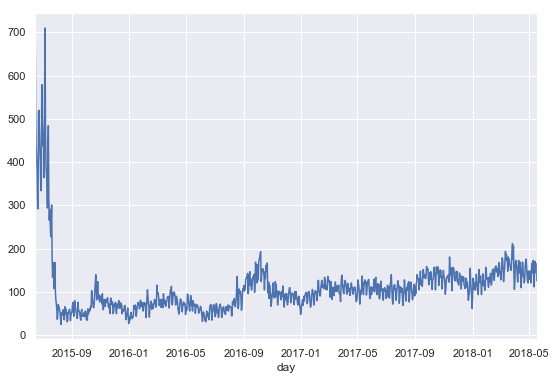

In [10]:
events_data.groupby('day') \
    .user_id.nunique().plot();

In [11]:
events = events_data.pivot_table(index='user_id', 
                        columns='action', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

In [12]:
users_scores = submissions_data.pivot_table(index='user_id', 
                        columns='submission_status', 
                        values='step_id', 
                        aggfunc='count', 
                        fill_value=0).reset_index()

In [13]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

In [14]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [15]:
gap_data = gap_data / (24 * 60 * 60)

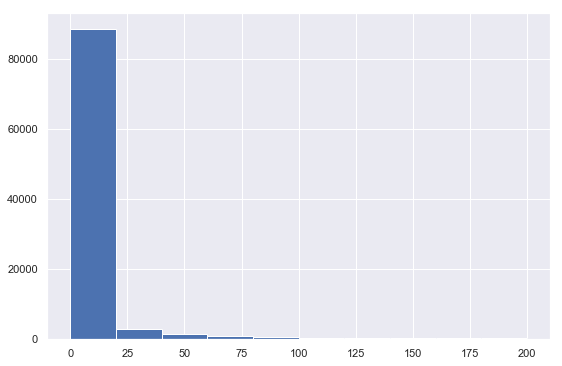

In [16]:
gap_data[gap_data < 200].hist()

In [17]:
gap_data.quantile(0.95)

59.760440972222156

In [18]:
gap_data.quantile(0.90)

18.325995370370403

In [19]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [20]:
users_scores.sort_values(by='correct', ascending=False).head()

submission_status,user_id,correct,wrong
439,1046,421,513
2099,5552,186,93
6415,17135,168,177
2344,6183,142,65
3208,8461,135,42


In [23]:
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

In [24]:
now = 1526772811
threshold = 30 * 24 * 60 * 60

In [27]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > threshold

In [28]:
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [32]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')

In [33]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN


In [38]:
users_data = users_data.merge(events, how='outer', on='user_id')

In [41]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [39]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,NaN,NaN,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,NaN,NaN,1,1,0,1


In [43]:
users_data.merge(users_days, how='outer', on='user_id').head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,NaN,NaN,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,NaN,NaN,1,1,0,1,1


In [44]:
users_data = users_data.merge(users_days, how='outer', on='user_id')

In [47]:
users_data.user_id.nunique()

19234

In [48]:
events_data.user_id.nunique()

19234

In [49]:
users_data['passed_course'] = users_data.passed > 170

In [50]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,NaN,NaN,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,NaN,NaN,1,1,0,1,1,False
